# Trace Demo

This notebook uses the trace package to run through multiple example calculations. The following are included:

1. A toy example
2. Calculating RMS of plano-convex lens
3. Optimizing a lens
4. Modeling a telescope

The idea is to demonstrate increasingly advanced usage of trace.

**NOTICE:**<br>
Each section in the notebook can be run independently, but *must be run in order*!

In [58]:
import numpy as np
import matplotlib.pyplot as plt

import trace as tr

In [59]:
# Can be fun for interactive 3D graphics
# %matplotlib notebook

## Basic Usage (Toy Example)

The following demonstrates the basic principles of trace.

In [71]:
# Make a scene and include a lense
scene = tr.Scene()

# Convex at origin, pointing upwards
lens = tr.SphereLens(1, 0.8, 1, pos=tr.pos(0, 0, 0), axis=tr.vec(0, 0, 1), n=2.0)
lamp = tr.DenseSource(pos=tr.pos(0, 0, 2), k=tr.vec(0, 0, -1), radius=0.8)

In [72]:
# Add the elements to the simulation and run (notice that many elements can be added at once)
scene.add(lens, lamp)
scene.trace()

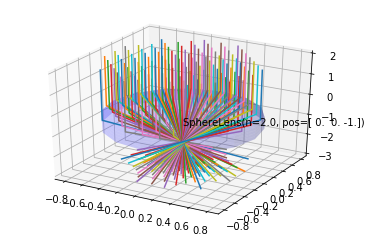

In [73]:
# Show result
tr.graphics.render_3d(scene, extend=3)
plt.show()

## Modelling a plano-convex singlet lens

This examples demonstrates how the trace package can be used to complete task 15 in the laboratory manual.

Calcualting the RMS for the curved surface facing the beam is done in great detail with plots of all intermediate steps. The other way around is done in a single cell, showing only a plot of the final scene and result.

In [76]:
# Start by preparing a scene
scene = tr.Scene()

# Pano-convex lens (all lengths in mm)
# This lens faces the source with the curved surface
lens_front = tr.SphereLens(0.02, 6, 5, pos=tr.pos(0,0,0), axis=tr.vec(1,0,0), n=1.5168)
lens_back = tr.PlaneLens(pos=tr.pos(-1,-6,-6), normal=tr.vec(1,0,0), width=tr.vec(0,12,0), height=tr.vec(0,0,12), n=1)

lamp = tr.DenseSource(pos=tr.pos(25,0,0), k=tr.vec(-1,0,0), radius=5, density=1)

scene.add(lens_front, lens_back, lamp)

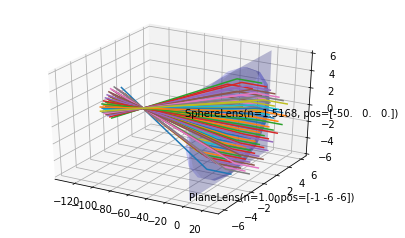

In [77]:
# Render the current scene, to validate the
# placement of objects is correct
scene.trace()
tr.graphics.render_3d(scene, extend=130)
plt.show()

In [78]:
# Find focal point using single ray
scene = scene.reset()
focus_ray = tr.Ray(tr.pos(8,0.1,0.1), k=tr.vec(-1,0,0))
scene.add(focus_ray)
scene.trace()

pt_ray, pt_axi = focus_ray.intersect_axis(tr.pos(0,0,0), tr.vec(1,0,0))
print("Focal Point: {}".format(pt_axi))

Focal Point: [-97.08971706   0.           0.        ]


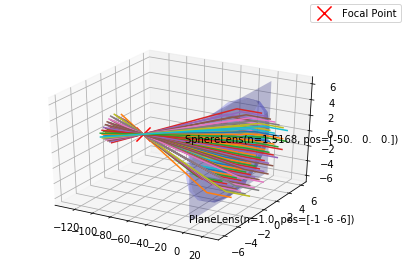

In [79]:
# Display the focal point
fig = tr.graphics.render_3d(scene, extend=130)
fig.axes[0].scatter(*pt_axi, color="red", marker="x", s=200, label="Focal Point")
fig.legend()
plt.show()

RMS: 0.007609925995173922mm


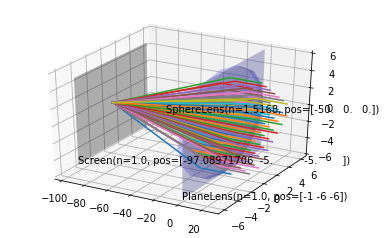

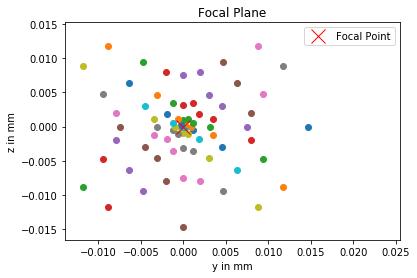

In [80]:
# Now that we know the focal point, place a screen there and record the rms
scene = scene.reset() # Note: This automagically removes the focus ray
screen = tr.Screen(pos=pt_axi-tr.vec(0,5,5), normal=tr.vec(1,0,0), width=tr.vec(0,10,0), height=tr.vec(0,0,10))

scene.add(screen)
scene.trace()

# Calculate RMS from focal point
print("RMS: {}mm".format(screen.RMS(pt_axi)))

# Make nice output graphics
tr.graphics.render_3d(scene)
ax = tr.graphics.render_2d(screen).axes[0]

ax.set_title("Focal Plane")
ax.plot(pt_axi[1], pt_axi[2], "xr", label="Focal Point", markersize=14)
ax.set_xlabel("y in mm")
ax.set_ylabel("z in mm")
ax.legend()

plt.show()

Focal Point: [-101.74833565    0.            0.        ]
RMS: 0.030094346151877786mm


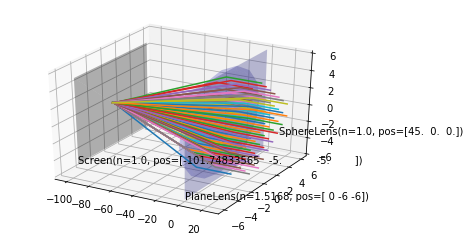

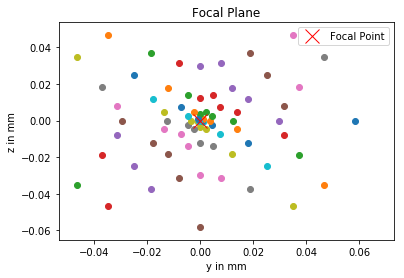

In [81]:
# Without running through all the visuals, do the same trace from the other side
scene = tr.Scene()

# Pano-convex lens (all lengths in mm)
# This lens faces the source with the flat surface
lens_front = tr.SphereLens(-0.02, 6, 0, pos=tr.pos(-5,0,0), axis=tr.vec(1,0,0), n=1)
lens_back = tr.PlaneLens(pos=tr.pos(0,-6,-6), normal=tr.vec(1,0,0), width=tr.vec(0,12,0), height=tr.vec(0,0,12), n=1.5168)

scene.add(lens_front, lens_back, lamp) # Note: Reuse lamp from above

# Find focal point
focus_ray = tr.Ray(tr.pos(8,0.1,0.1), k=tr.vec(-1,0,0))
scene.add(focus_ray)
scene.trace()
_, pt_axi = focus_ray.intersect_axis(tr.pos(0,0,0), tr.vec(1,0,0))
print("Focal Point: {}".format(pt_axi))

# Insert screen at focal point
scene = scene.reset()
screen = tr.Screen(pos=pt_axi-tr.vec(0,5,5), normal=tr.vec(1,0,0), width=tr.vec(0,10,0), height=tr.vec(0,0,10))
scene.add(screen)
scene.trace()

# Calculate RMS from focal point
print("RMS: {}mm".format(screen.RMS(pt_axi)))

# Make nice output graphics
tr.graphics.render_3d(scene)
ax = tr.graphics.render_2d(screen).axes[0]

ax.set_title("Focal Plane")
ax.plot(pt_axi[1], pt_axi[2], "xr", label="Focal Point", markersize=14)
ax.set_xlabel("y in mm")
ax.set_ylabel("z in mm")
ax.legend()

plt.show()

### Result

This example should demonstrate the ease of use provided by trace, as well as how this lens has a much worse performace the 'wrong' way around.

Numerical results for RMS of the plano-convex lens:
1. Curved surface facing beam: ${RMS}_\text{c} = 0.00761\text{mm}$
2. Flat surface facing beam: ${RMS}_\text{f} = 0.03009\text{mm}$

The RMS when facing the beam with the flat surface is more than $30\times$ greater!

## Lens optimization

This optimizes the design of a lens using trace.

## Modelling a telescope

This example uses trace to model a simple telescope.